## Imports & Setup

In [1]:
import os
import pandas as pd
# import datetime
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import numpy as np
# from scipy import stats
# import random
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
from sklearn import model_selection

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb

import time
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
%matplotlib inline

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/lightgbm/__init__.py:42: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  warnings.warn("Starting from version 2.2.1, the library file in distribution wheels for macOS "


In [3]:
print(os.getcwd())
os.chdir('/Users/liuyang/Desktop/Springboard_Capstone') 
print(os.getcwd())

/Users/liuyang/Desktop/Springboard_Capstone/notebooks
/Users/liuyang/Desktop/Springboard_Capstone


In [4]:
df = pd.read_csv('data/preprocessed_train.csv')

In [5]:
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,city_149,0.689,1,1,0,2,1,1,2,4,1,106,0
1,city_83,0.923,1,1,0,2,1,3,1,2,1,69,0
2,city_16,0.910,1,1,0,2,1,2,1,1,1,4,0
3,city_64,0.666,1,1,0,2,1,3,1,4,1,26,0
4,city_100,0.887,1,0,0,2,1,2,1,4,1,88,1


In [6]:
df.shape

(18359, 13)

In [7]:
X = df.drop(['target'],axis=1)
y = df['target']

In [8]:
# Encode column 'city'
enc = LeaveOneOutEncoder(cols=['city'])
X_enc = enc.fit_transform(X,y)
X_enc.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,0.125000,0.689,1,1,0,2,1,1,2,4,1,106
1,0.099291,0.923,1,1,0,2,1,3,1,2,1,69
2,0.093164,0.910,1,1,0,2,1,2,1,1,1,4
3,0.101695,0.666,1,1,0,2,1,3,1,4,1,26
4,0.159259,0.887,1,0,0,2,1,2,1,4,1,88


In [9]:
# Scale X 
X_scaled = StandardScaler().fit_transform(X_enc)

In [10]:
# Split train test set
X_train,X_test,y_train,y_test = train_test_split(X_scaled, y, test_size=0.30, stratify=y, random_state=63)

In [11]:
# Confirm there's positive class in the test set.
y_test.value_counts()

0    4780
1     728
Name: target, dtype: int64

## 1. Try Logistic regression 

In [11]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)

y_pred=logreg.predict(X_test)

score(y_test, y_pred, pos_label=1,average='binary') 
metrics.confusion_matrix(y_test, y_pred,labels=[1,0])

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[   0,  728],
       [   0, 4780]])

As data is imbalanced so there's no positive class predicted, therefore Recall is zero, 
Precision and fscore are ill-defined.

In [12]:
y_pred_proba = logreg.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

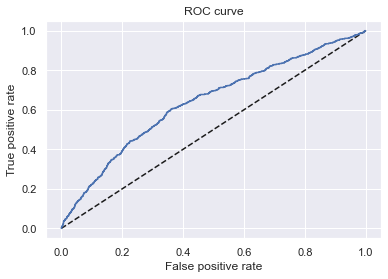

In [13]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [14]:
auc = metrics.auc(fpr,tpr)
print('AUC:{0:.3f}'.format(auc))

AUC:0.638


As you can see the overall, the performance from model logistic regression is not very ideal. 

## 2. Try DecisionTree model

In [15]:
model2 = DecisionTreeClassifier(random_state=63)
model2.fit(X_train, y_train)

y_pred2 = model2.predict(X_test)

# get precision, recall, fscore
score(y_test, y_pred2, pos_label=1,average='binary')   

(0.9904240766073872, 0.9945054945054945, 0.9924605894448253, None)

In [16]:
# get accuracy
accuracy_score(y_test,y_pred2)

0.9980029048656499

In [17]:
(y_pred2 == y_test).value_counts()

True     5497
False      11
Name: target, dtype: int64

## 3. Train model with SMOTE method

In [12]:
os = SMOTE(random_state=63)
#columns = X_train.columns

#os_data_X,os_data_y=os.fit_sample(X_train, y_train)
X_os, y_os=os.fit_sample(X_train, y_train.ravel())

In [13]:
print(X_os.shape)
print(y_os.shape)

(22308, 12)
(22308,)


In [20]:
# make sure the numbers of positive and negative class are the same
np.unique(y_os,return_counts=True)

(array([0, 1]), array([11154, 11154]))

In [14]:
# Split the over sampled train_data: X_os, y_os to a new train_test set.
X_os_train, X_os_test, y_os_train, y_os_test = train_test_split(X_os, y_os, test_size=0.3, random_state=63)

In [22]:
np.unique(y_os_train,return_counts=True)

(array([0, 1]), array([7853, 7762]))

### First try logistic regression on the new train data 

In [23]:
logreg = LogisticRegression()
logreg.fit(X_os_train, y_os_train)

LogisticRegression()

In [24]:
y_os_pred = logreg.predict(X_os_test)
y_os_pred_proba = logreg.predict_proba(X_os_test)[:,1]
fpr, tpr, threshold = roc_curve(y_os_test, y_os_pred_proba)
precision, recall, fscore,support = score(y_os_test, y_os_pred, pos_label=1,average='binary')

In [25]:
print("precision: %s"%round(precision,3), 'recall:', round(recall,3), 'fscore:', round(fscore,3), 'auc:',round(metrics.auc(fpr,tpr),3))

precision: 0.635 recall: 0.529 fscore: 0.577 auc: 0.642


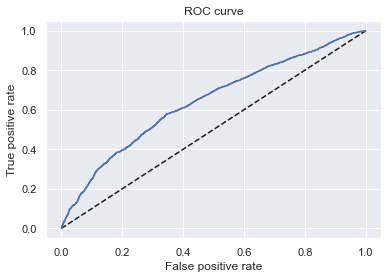

In [26]:
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

In [27]:
# create a new dataframe for predicted probability and labels(in the y_os_test)
predProba_label = pd.DataFrame()
predProba_label['proba'] = y_os_pred_proba
predProba_label['label'] = np.array(y_os_test)

predProba_label.head()

,proba,label
0,0.787746,1
1,0.401585,0
2,0.383597,0
3,0.386452,1
4,0.503373,0


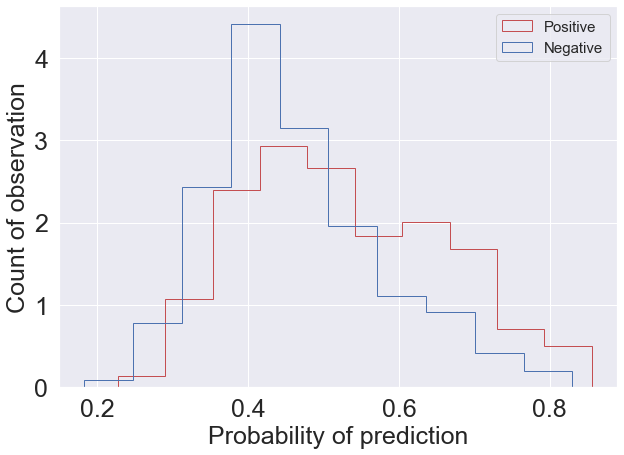

In [28]:
# Make the histogram
plt.figure(figsize=(10,7))
plt.hist(predProba_label[predProba_label.label==1].proba, density=True, histtype='step',label='Positive',color='r')
plt.hist(predProba_label[predProba_label.label==0].proba, density=True, histtype='step',label='Negative')
plt.xlabel('Probability of prediction', fontsize=25)
plt.ylabel('Count of observation', fontsize=25)
plt.legend(fontsize=15)
plt.tick_params(axis='both', labelsize=25, pad=5)
plt.show() 

As we can see from the predicted probability distribution, our two observation classes overlap among most of the probabilities.
Which means we can not optimize the model classification accuracy by lowering or raising the threshold/cut-off. (By default it's 0.5). Therefore in the next step we will use other classification models to train the oversampled data and see if we will get better result than logistic regression.

## 4. Different models on the oversampled data set.

In [29]:
# model_res = {}

# models = {'LR': LogisticRegression(),
#          'GNB': GaussianNB(),
#          'KNN': KNeighborsClassifier(),
#          'SVC': SVC(probability=True, random_state=4),
#          'DT': DecisionTreeClassifier(random_state=4),
#          'RF': RandomForestClassifier(random_state=4),
#          'GB': GradientBoostingClassifier(random_state=4)}

# for i, model in models.items():
#     start = time.time()
#     model.fit(X_os_train, y_os_train)
#     end = time.time()
#     fit_time = end - start
    
#     start = time.time()
#     y_os_pred = model.predict(X_os_test)
#     end = time.time()
#     pred_time = end - start
    
#     y_os_pred_proba = model.predict_proba(X_os_test)[:,1]
#     fpr,tpr,_ = roc_curve(y_os_test, y_os_pred_proba,pos_label=1)
#     auc = metrics.auc(fpr,tpr)
    
#     precision, recall, fscore, _ = score(y_os_test, y_os_pred, pos_label=1,average='binary')    
#     model_res[i] = accuracy_score(y_os_test,y_os_pred), precision, recall, fscore, auc, fit_time, pred_time

# # Put the model evaluation result in a data frame.
# df_model_eval = pd.DataFrame(model_res.values(),
#                              index=['LogisticRegression','GaussianNaiveBayes','KNeighbors','SVM',
#                                                        'DecisionTree','RandomForest','GradientBoosting'],
#                              columns=['accuracy','precision','recall','fscore','auc','fit_time','pred_time']).reset_index()

# df_model_eval = df_model_eval.round(3)
# df_model_eval = df_model_eval.rename(columns={'index':'model'})
# df_model_eval

In [30]:
np.unique(y_os_train,return_counts=True)

(array([0, 1]), array([7853, 7762]))

In [159]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


def model_eval(model_name,X,y):
    scoring = {
           'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score),
           'roc_auc' : make_scorer(roc_auc_score, needs_proba=True)}

    kfold = KFold(n_splits=5)
    model = model_name

    model_res = model_selection.cross_validate(
                                          estimator=model,
                                          X=X,
                                          y=y,
                                          cv=kfold,
                                          scoring=scoring)
    
    return pd.DataFrame(model_res).round(3)

In [58]:
# create a empty list to put the average model test_score from the validation
model_score_average = []

# list up models we want to explore with.
index = ['LR','GNB','KNN','SVC','DT','RF','GB','XGB','LightGB']
models = [LogisticRegression(),
          GaussianNB(),
          KNeighborsClassifier(),
          SVC(probability=True, random_state=63),
          DecisionTreeClassifier(random_state=63),
          RandomForestClassifier(random_state=63),
          GradientBoostingClassifier(random_state=63),
          XGBClassifier(random_state=63),
          lgb.LGBMClassifier(objective='binary',random_state=63)]

# Loop inside the models and average the test_score. (test_score contains: accuracy, precision, recall, fscore, roc_auc_score)
# Append the avarage score to list 'model_score_average' 
for model in models:
    model_score_average.append(model_eval(model,X_os_train,y_os_train).mean())
    #model_score_average.append(model_eval(model,X_train,y_train).mean())

# put the model_score_average into a dataframe 
df_model_eval = pd.DataFrame(model_score_average,index=index).round(5)
df_model_eval = df_model_eval.reset_index().rename(columns={'index':'model'})

df_model_eval

/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/liuyang/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_cl

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,LR,0.0106,0.0068,0.8680,0.0000,0.0000,0.0000,0.6334
1,GNB,0.0034,0.0082,0.8068,0.2610,0.2514,0.2560,0.6230
2,KNN,0.0696,0.3228,0.8518,0.2356,0.0544,0.0874,0.5614
3,SVC,13.4884,0.3146,0.8680,0.0000,0.0000,0.0000,0.5126
4,DT,0.0130,0.0048,0.9982,0.9930,0.9954,0.9944,0.9970
5,RF,0.5076,0.0752,0.9458,0.9980,0.5902,0.7418,0.9818
6,GB,0.6188,0.0114,0.9776,1.0000,0.8276,0.9048,0.9970
7,XGB,0.2202,0.0094,0.9998,1.0000,0.9982,0.9990,1.0000
8,LightGB,0.0786,0.0226,0.9984,1.0000,0.9880,0.9942,1.0000


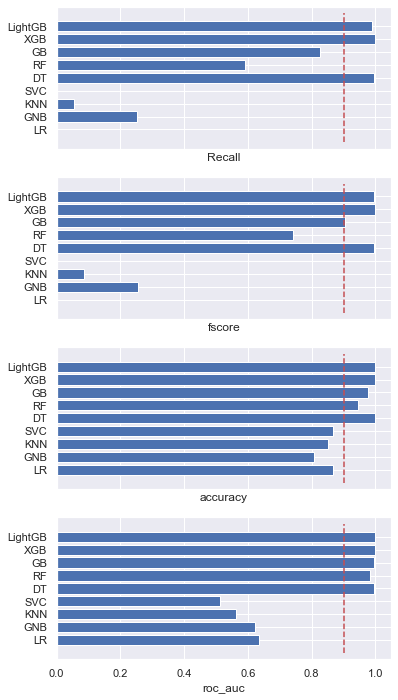

In [59]:
fig,axs = plt.subplots(4,1, figsize=(6,12),sharex=True)

axs[0].barh('model', 'test_recall', data=df_model_eval)
axs[1].barh('model', 'test_f1_score', data=df_model_eval)
axs[2].barh('model', 'test_accuracy', data=df_model_eval)
axs[3].barh('model', 'test_roc_auc',data=df_model_eval)

axs[0].set_xlabel('Recall')
axs[1].set_xlabel('fscore')
axs[2].set_xlabel('accuracy')
axs[3].set_xlabel('roc_auc')


axs[0].plot([0.9,0.9],[-1,9],'r--')
axs[1].plot([0.9,0.9],[-1,9],'r--')
axs[2].plot([0.9,0.9],[-1,9],'r--')
axs[3].plot([0.9,0.9],[-1,9],'r--')
plt.show()

In [60]:
# check std of each model score from the 5fold cross validation
model_score_std = []
index = ['DT','RF','GB','XGB','LightGB']
models = [DecisionTreeClassifier(random_state=63),
          RandomForestClassifier(random_state=63),
          GradientBoostingClassifier(random_state=63),
          XGBClassifier(random_state=63),
          lgb.LGBMClassifier(objective='binary',random_state=63)]

for model in models:
    model_score_std.append(model_eval(model,X_os_train,y_os_train).std())
    #model_score_std.append(model_eval(model,X_train,y_train).std())

df_model_std = pd.DataFrame(model_score_std,index=index).round(6)
df_model_std = df_model_std.reset_index().rename(columns={'index':'model'})

In [61]:
df_model_std.sort_values(['test_recall','test_accuracy'])

,model,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
3,XGB,0.005020,0.000000,0.000447,0.000000,0.002683,0.001414,0.000000
0,DT,0.001095,0.001304,0.000837,0.003082,0.005273,0.002966,0.002915
4,LightGB,0.005612,0.000447,0.000894,0.000000,0.005523,0.002950,0.000000
1,RF,0.064104,0.001225,0.004919,0.002739,0.008044,0.006943,0.002588
2,GB,0.011662,0.000548,0.006656,0.000000,0.058462,0.035478,0.001871


We can see among 9 models, LightGB, XGB, GB, RF, DT overall have very good performance. 
Therefore we will focus on these 5 models and optimize their hyperparameters via BayesianOptimization. 

## 5. Model optimization: hyperparameter tuning (Bayesian optimization)

In [19]:
from bayes_opt import BayesianOptimization

### Hyperparameter tuning for Lightgbm

In [203]:
def lgb_eval(learning_rate,num_leaves, max_depth, subsample, colsample_bytree, min_child_samples, 
             min_child_weight, min_data_in_leaf, L2, L1):
    
    params = {
        "objective" : "binary",
        "is_unbalance": True,
        "learning_rate" : learning_rate,
        "num_leaves" : int(num_leaves),
        "max_depth" : int(max_depth),
        "subsample" : subsample,
        "colsample_bytree" : colsample_bytree,
        "min_child_samples" : int(min_child_samples),
        "min_child_weight" : int(min_child_weight),
        "min_data_in_leaf" : int(min_data_in_leaf),
        "reg_lambda" : L2,
        "reg_alpha" : L1,
        "num_threads" : 20,
        "subsample_freq" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1
    }
    lgtrain = lgb.Dataset(X_os_train, y_os_train)
    #lgtrain = lgb.Dataset(X_train, y_train)
    cv_result = lgb.cv(params,
                       lgtrain,
                       num_boost_round = 1000,
                       metrics='auc',
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    
    return cv_result['auc-mean'][-1]

In [204]:
lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.001, 0.4),
                                        'num_leaves': (25, 4000),
                                        'max_depth': (0, 100),
                                        'subsample': (0.5, 1),
                                        'colsample_bytree': (0.4,1),
                                        'min_child_samples': (50, 10000),
                                        'min_child_weight' : (0, 0.05),
                                        'min_data_in_leaf': (10, 2000),
                                        'L2': (0.0, 100),
                                        'L1': (0.0, 1)
                                        
                                        })

lgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   |    L1     |    L2     | colsam... | learni... | max_depth | min_ch... | min_ch... | min_da... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9073   |  0.791    |  27.25    |  0.7624   |  0.3217   |  9.341    |  3.73e+03 |  0.03676  |  1.882e+0 |  229.3    |  0.5872   |
|  2        |  0.9996   |  0.2296   |  0.2454   |  0.7519   |  0.04821  |  0.06607  |  8.787e+0 |  0.03111  |  164.3    |  95.07    |  0.7825   |
|  3        |  0.874    |  0.1252   |  7.725    |  0.9069   |  0.04259  |  70.35    |  6.934e+0 |  0.02472  |  1.454e+0 |  3.894e+0 |  0.5765   |
|  4        |  0.9703   |  0.7193   |  57.76    |  0.6592   |  0.1825   |  99.91    |  6.055e+0 |  0.03782  |  816.9    |  1.463e+0 |  0.5261   |
|  5        |  0.9995   |  0.3089   |  6.566    |  0.6426   |  0.03657  |  82.2     |  2.207e+0 |  0.01878  |  168.6    |  2

In [226]:
lgbBO.max

{'target': 0.9998940366523277,
 'params': {'L1': 0.2863086833634504,
  'L2': 59.75561608407822,
  'colsample_bytree': 0.7344041762304885,
  'learning_rate': 0.3085611218142796,
  'max_depth': 90.5225566378267,
  'min_child_samples': 7911.850206227465,
  'min_child_weight': 0.041038501347913287,
  'min_data_in_leaf': 13.466191265932995,
  'num_leaves': 2896.5724908323114,
  'subsample': 0.9087773199479944}}

In [227]:
# test result of LGBM model with tuned hyperparameter
# dataset: X_os_test, y_os_test with crossvalidation(5)
model_eval(lgb.LGBMClassifier
           (objective='binary', 
            L1=0.286,
            L2=60,
            colsample_bytree=0.734,
            learning_rate= 0.309,
            max_depth = 91,
            min_child_samples= 7912,
            min_child_weight= 0.041,
            min_data_in_leaf= 13,
            num_leaves=2897,
            subsample= 0.909,random_state=63),
            X_os_test,y_os_test).mean()

fit_time          0.2458
score_time        0.0146
test_accuracy     0.9930
test_precision    0.9996
test_recall       0.9860
test_f1_score     0.9928
test_roc_auc      0.9996
dtype: float64

In [219]:
# Test result of LGBM model with default value 
# dataset: X_os_test, y_os_test with crossvalidation(5)
model_eval(lgb.LGBMClassifier(objective='binary',random_state=63),X_os_test,y_os_test).mean()

fit_time          0.0880
score_time        0.0142
test_accuracy     0.9898
test_precision    0.9998
test_recall       0.9800
test_f1_score     0.9898
test_roc_auc      0.9992
dtype: float64

In [228]:
# final test with tuned hyperparameters on X_test, y_test without crossvalidation.
model = lgb.LGBMClassifier(objective='binary', 
            L1=0.286,
            L2=60,
            colsample_bytree=0.734,
            learning_rate= 0.309,
            max_depth = 91,
            min_child_samples= 7912,
            min_child_weight= 0.041,
            min_data_in_leaf= 13,
            num_leaves=2897,
            subsample= 0.909,random_state=63)
    
model.fit(X_os_train,y_os_train)
y_pred = model.predict(X_test)

# get precision, recall, fscore.
score(y_test, y_pred, pos_label=1,average='binary') 


(1.0, 0.9972527472527473, 0.9986244841815681, None)

In [210]:
# final test with default parameter values on X_test, y_test withou crossvalidation.
model = lgb.LGBMClassifier(objective='binary', 
            random_state=63)
    
model.fit(X_os_train,y_os_train)
y_pred = model.predict(X_test)

# get precision, recall, fscore.
score(y_test, y_pred, pos_label=1,average='binary') 

(1.0, 0.9848901098901099, 0.9923875432525952, None)

## Hyperparameter tuning for XGB

In [213]:
def XGB_eval(learning_rate, gamma, subsample, colsample_bytree, max_depth, L2, L1, min_child_weight):
    params = {
        "objective" : "binary:logistic",
        "eta" : learning_rate,
        "gamma" : gamma,
        "subsample" : subsample,
        "colsample_bytree" : colsample_bytree,
        "max_depth" : int(max_depth),
        "min_child_weight" : int(min_child_weight),
        "lambda" : L2,
        "alpha" : L1,
        "seed" : 63,
        "nthread": 4}
    
    
    xgtrain = xgb.DMatrix(X_os_train, label=y_os_train)
    #xgtrain = xgb.DMatrix(X_train, label=y_train)
    cv_result =xgb.cv(params,
                      xgtrain,
                      early_stopping_rounds=100,
                      num_boost_round=70,
                      stratified=True,
                      nfold=3,
                      metrics= 'auc')
                       
          
    return cv_result['test-auc-mean'].iloc[-1]

In [214]:
xgbBO = BayesianOptimization(XGB_eval, {'learning_rate': (0.001,0.4),
                                        'gamma': (0,20),
                                        'subsample': (0.5,1),
                                        'colsample_bytree': (0.4,1),
                                        'max_depth': (1,2000),
                                        'min_child_weight': (1,20),
                                        'L2':(0, 100),
                                        'L1': (0, 1),
                                        })
                                        
                                        

xgbBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   |    L1     |    L2     | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9913   |  0.9615   |  30.94    |  0.4865   |  11.08    |  0.3338   |  930.9    |  7.651    |  0.5495   |
|  2        |  0.9991   |  0.1339   |  22.15    |  0.6209   |  1.402    |  0.3147   |  1.429e+0 |  4.809    |  0.5628   |
|  3        |  0.9995   |  0.3181   |  26.03    |  0.8807   |  2.223    |  0.306    |  1.433e+0 |  2.748    |  0.7721   |
|  4        |  0.979    |  0.7708   |  87.25    |  0.9721   |  16.41    |  0.3393   |  1.53e+03 |  1.288    |  0.6264   |
|  5        |  0.9931   |  0.9696   |  84.98    |  0.5585   |  8.605    |  0.3454   |  1.378e+0 |  1.256    |  0.8246   |
|  6        |  0.9993   |  0.7402   |  1.185    |  0.5432   |  2.843    |  0.09956  |  1.293e+0 |  5.227    |  0.5489   |
|  7        |  0.9973   

In [215]:
xgbBO.max

{'target': 0.9994549999999999,
 'params': {'L1': 0.31812277019823165,
  'L2': 26.032587099894876,
  'colsample_bytree': 0.880728758550327,
  'gamma': 2.2227295555114823,
  'learning_rate': 0.30600937266155626,
  'max_depth': 1433.4944313030321,
  'min_child_weight': 2.7478425233564474,
  'subsample': 0.7721187606000149}}

In [216]:
xgbBO.max.items()

dict_items([('target', 0.9994549999999999), ('params', {'L1': 0.31812277019823165, 'L2': 26.032587099894876, 'colsample_bytree': 0.880728758550327, 'gamma': 2.2227295555114823, 'learning_rate': 0.30600937266155626, 'max_depth': 1433.4944313030321, 'min_child_weight': 2.7478425233564474, 'subsample': 0.7721187606000149})])

## Hyperparameter tuning for RF

In [15]:
from sklearn.model_selection import cross_val_score

In [88]:
def rf_cv(X, y, **kwargs):
    estimator = RandomForestClassifier(**kwargs)
    cval = cross_val_score(estimator, X, y, scoring = 'roc_auc', cv = 3)
    #cval = cross_val_score(estimator, X_train, y_train, scoring = 'roc_auc', cv = 3)
    return cval.mean()


def BayesianOptimization_rf(X, y):
    def rf_crossval(n_estimators,  max_depth, 
                    min_samples_split, max_leaf_nodes, min_samples_leaf,random_state=63):
        
        return rf_cv(
            X = X,
            y = y,
            bootstrap = True)
    
    rfBO = BayesianOptimization(
        f = rf_crossval,
        pbounds = {
            "n_estimators" : (10, 400),
            #"max_features" : 
            "max_depth" : (0,50),
            "min_samples_split" : (0,5000),
            "max_leaf_nodes" : (0,200),
            "min_samples_leaf" : (0,0.5)
        }
    )
    rfBO.maximize(n_iter = 10,init_points=2)
    print("Final result:", rfBO.max)

In [89]:
BayesianOptimization_rf(X_os_train,y_os_train)

|   iter    |  target   | max_depth | max_le... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
|  1        |  0.9955   |  31.41    |  44.55    |  0.1136   |  3.75e+03 |  87.03    |
|  2        |  0.9958   |  6.243    |  157.5    |  0.07526  |  2.216e+0 |  108.9    |
|  3        |  0.9956   |  42.56    |  10.11    |  0.4791   |  3.025e+0 |  258.3    |
|  4        |  0.9951   |  48.14    |  174.9    |  0.4166   |  2.096e+0 |  85.05    |
|  5        |  0.9953   |  0.7472   |  34.92    |  0.1061   |  2.652e+0 |  389.3    |
|  6        |  0.9957   |  1.193    |  20.94    |  0.3576   |  4.064e+0 |  43.98    |
|  7        |  0.9954   |  12.99    |  155.4    |  0.3845   |  2.218e+0 |  98.81    |
|  8        |  0.9954   |  20.55    |  21.53    |  0.2457   |  3.408e+0 |  399.3    |
|  9        |  0.9954   |  3.928    |  123.1    |  0.3525   |  4.945e+0 |  371.8    |
|  10       |  0.9952   |  6.851    |  81.22    |  0.2

In [90]:
model = RandomForestClassifier(max_depth=6.24, 
                               max_leaf_nodes=157, min_samples_leaf=0.075,
                               min_samples_split=2216,random_state=63)

In [80]:
model = RandomForestClassifier(random_state=63)

In [173]:
model_eval(RandomForestClassifier(max_depth=6.24, 
                               max_leaf_nodes=157, min_samples_leaf=0.075,
                               min_samples_split=2216,random_state=63),X_os_train,y_os_train)

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_f1_score,test_roc_auc
0,0.384,0.046,0.672,0.703,0.603,0.649,0.731
1,0.339,0.043,0.677,0.713,0.609,0.657,0.739
2,0.334,0.043,0.671,0.699,0.621,0.658,0.747
3,0.294,0.038,0.660,0.657,0.603,0.629,0.738
4,0.285,0.037,0.647,0.655,0.586,0.618,0.727


In [92]:
metrics.confusion_matrix(y_test, y_pred,labels=[1,0])

array([[ 426,  302],
       [1264, 3516]])

In [93]:
score(y_test, y_pred, pos_label=1,average='binary')   

(0.25207100591715975, 0.5851648351648352, 0.3523573200992556, None)

## Hyperparameter tuning for LogisticRegression

In [160]:
def lr_cv(X, y, **kwargs):
    estimator = LogisticRegression(**kwargs)
    cval = cross_val_score(estimator, X, y, scoring = 'recall', cv = 3)
    return cval.mean()


def BayesianOptimization_lr(X, y):
    def lr_crossval(C):
        
        return rf_cv(
            X = X,
            y = y)
    
    lrBO = BayesianOptimization(
        f = lr_crossval,
        pbounds = {
            "C" : (0, 1000)
            #"l2" : (0,100)
        }
    )
    lrBO.maximize(n_iter = 10,init_points=2)
    print("Final result:", lrBO.max)

In [161]:
BayesianOptimization_lr(X_os_train,y_os_train)

|   iter    |  target   |     C     |
-------------------------------------
|  1        |  0.9953   |  251.2    |
|  2        |  0.9951   |  470.1    |
|  3        |  0.995    |  249.9    |
|  4        |  0.9952   |  251.4    |
|  5        |  0.9953   |  251.1    |
|  6        |  0.9953   |  250.7    |
|  7        |  0.9949   |  172.8    |
|  8        |  0.9955   |  612.9    |
|  9        |  0.9956   |  194.9    |
|  10       |  0.9953   |  194.6    |
|  11       |  0.9956   |  195.2    |
|  12       |  0.9954   |  612.5    |
Final result: {'target': 0.9955883919488554, 'params': {'C': 195.22672000342865}}


In [157]:
model = LogisticRegression(C=934)
model.fit(X_os_train,y_os_train)
y_pred = model.predict(X_os_test)



In [158]:
metrics.confusion_matrix(y_os_test, y_pred,labels=[1,0])

array([[1795, 1597],
       [1033, 2268]])

In [159]:
score(y_os_test, y_pred, pos_label=1,average='binary')   

(0.6347241867043847, 0.5291863207547169, 0.5771704180064309, None)

In [75]:
finmodel = DecisionTreeClassifier(random_state=63)
finmodel.fit(X_os_train, y_os_train)
fin_y_pred = finmodel.predict(X_test)

# get precision, recall, fscore
score(y_test, fin_y_pred, pos_label=1,average='binary')    

(0.9958847736625515, 0.9972527472527473, 0.9965682910089224, None)

In [76]:
finmodel = DecisionTreeClassifier(random_state=63)
finmodel.fit(X_os_train, y_os_train)
fin_y_pred = finmodel.predict(X_test)

# get precision, recall, fscore
score(y_test, fin_y_pred, pos_label=1,average='binary')  

(0.9958847736625515, 0.9972527472527473, 0.9965682910089224, None)

In [77]:
np.unique((fin_y_pred == y_test),return_counts=True)

(array([False,  True]), array([   5, 5503]))

In [78]:
y_os_test.shape

(6693,)

## What shall I do for the next step? I am a bit lost now as it didn't go as I planned.

## My plan was to: 
1. train multiple models on the original data set (without oversampling), 
2. get model results
3. try to optimize the model performance by adopting SMOTE
4. get model results again and pick the best model
5. use gridsearchcv to tune best model's hyper parameters to optimize model.



Questions from me:
1) as now I figured out the DecisionTree model is performing so well on the original data, so I am not sure if it still makes sense to 
do the SMOTE trick with other models.

2) as I've asked you earlier in this note book, when the model performs perfectly on the test set, what shall we do for the next? As I've  never run into this situation so far...

In [79]:
rf_cv(X_os_train,y_os_train)

0.6438432857326432

In [80]:
def rf_cv(min_samples_leaf, min_samples_split):
    params={"min_samples_leaf":min_samples_leaf,
            "min_samples_split" :min_samples_split}
    
    estimator = RandomForestClassifier()
    cval = cross_val_score(estimator, X_os_train, y_os_train, scoring = 'roc_auc', cv = 3, n_jobs = -1)
    return cval.mean()

In [81]:
rf_cv(25,6)

0.9950582301729614

In [82]:
rfBO = BayesianOptimization(rf_cv, {'min_samples_leaf': (1,100),
                                     'min_samples_split': (1,100)
                                        })

rfBO.maximize(n_iter=10, init_points=2)

|   iter    |  target   | min_sa... | min_sa... |
-------------------------------------------------
|  1        |  0.9957   |  88.85    |  13.13    |
|  2        |  0.9953   |  52.9     |  46.48    |
|  3        |  0.9956   |  90.05    |  12.98    |
|  4        |  0.9954   |  84.71    |  14.18    |
|  5        |  0.9954   |  88.56    |  10.72    |
|  6        |  0.9954   |  88.72    |  13.99    |
|  7        |  0.9952   |  89.07    |  12.87    |
|  8        |  0.9952   |  26.98    |  74.19    |
|  9        |  0.9954   |  10.12    |  84.17    |
|  10       |  0.9951   |  56.58    |  73.5     |
|  11       |  0.9951   |  79.64    |  57.56    |
|  12       |  0.9954   |  91.56    |  11.57    |
